In [30]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os

In [31]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

## Load datasets

In [32]:
dataset_path = '../../dataset/additional_datasets/'
dataset_name = 'Breast_GSE45827'
dataset_norm_suffix = '_norm'
dataset_pca_suffix = '_pca'
models_path = 'saved_models/SVM/'

with open('../../preprocessing/class_mapping.pickle', 'rb') as handle:
    class_mapping = pickle.load(handle)

In [33]:
df_norm = pd.read_csv(dataset_path + dataset_name + dataset_norm_suffix + '.csv', index_col=0)
X_norm = df_norm.drop('type', axis=1)
y_norm = df_norm.type

### Create PCA and SMOTE datasets

In [34]:
PCA_COMPONENTS = 90

def pca_dataset(X_train, X_test):
    pca = PCA(n_components=PCA_COMPONENTS)
    pca.fit(X_train)

    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca

In [35]:
def smote_dataset(X_train, y_train):
    smt = SMOTE()
    X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

    return X_train_smote, y_train_smote

### Experiment with GridSearch

In [36]:
def start_gridsearch(X, y, oversampling=False, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if oversampling:
        X_train, y_train = smote_dataset(X_train, y_train)
    if pca:
        X_train, X_test = pca_dataset(X_train, X_test)

    params = {
        'C': [0.1, 1, 10, 100, 1000], 
        'gamma': [4, 2, 1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
        'kernel': ['rbf', 'poly', 'linear', 'sigmoid']
    } 
    estimator = GridSearchCV(svm.SVC(), param_grid=params, verbose=4, cv=5)
    estimator.fit(X_train, y_train)

    print(estimator.best_params_)


In [37]:
# estimator_norm = start_gridsearch(X_norm, y_norm, oversampling=False, pca=False)

In [38]:
estimator_pca = start_gridsearch(X_norm, y_norm, oversampling=False, pca=True)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END ........C=0.1, gamma=4, kernel=rbf;, score=0.292 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=4, kernel=rbf;, score=0.250 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=4, kernel=rbf;, score=0.250 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=4, kernel=rbf;, score=0.250 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=4, kernel=rbf;, score=0.250 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=4, kernel=poly;, score=0.500 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=4, kernel=poly;, score=0.417 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=4, kernel=poly;, score=0.292 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=4, kernel=poly;, score=0.458 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=4, kernel=poly;, score=0.458 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=4, kernel=linear;, score=0.875 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=4, kernel=linea

## Train

In [39]:
def train(X, y, params={'C': 0.1, 'gamma': 1, 'kernel': 'linear'}, oversampling=False, pca=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    if oversampling:
        X_train, y_train = smote_dataset(X_train, y_train)
    if pca:
        X_train, X_test = pca_dataset(X_train, X_test)

    # implement support vector machine
    model = svm.SVC(kernel=params['kernel'], C=params['C'], gamma=params['gamma'])

    # fit model
    model.fit(X_train, y_train)

    print("F1 score: ", f1_score(y_test, model.predict(X_test), average='weighted') * 100, '%')

    preds = model.predict(X_test)
    return model, preds, y_test

In [40]:
norm_model, norm_pred, norm_true = train(X_norm, y_norm, params={'C': 0.1, 'gamma': 1, 'kernel': 'linear'}, oversampling=False, pca=False)
pca_model, pca_pred, pca_true = train(X_norm, y_norm, params={'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}, oversampling=False, pca=True)

F1 score:  90.58531601226099
F1 score:  90.58531601226099


In [41]:
norm_res_model, norm_res_pred, norm_res_true = train(X_norm, y_norm, params={'C': 0.1, 'gamma': 1, 'kernel': 'linear'}, oversampling=True, pca=False)
pca_res_model, pca_res_pred, pca_res_true = train(X_norm, y_norm, params={'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}, oversampling=True, pca=True)

F1 score:  90.58531601226099
F1 score:  90.58531601226099


## Results

In [42]:
f1_results = {
    'norm': f1_score(norm_true, norm_pred, average='weighted') * 100,
    'pca': f1_score(pca_true, pca_pred, average='weighted') * 100,
    'norm_res': f1_score(norm_res_true, norm_res_pred, average='weighted') * 100,
    'pca_res': f1_score(pca_res_true, pca_res_pred, average='weighted') * 100
}
acc_results = {
    'norm': accuracy_score(norm_true, norm_pred) * 100,
    'pca': accuracy_score(pca_true, pca_pred) * 100,
    'norm_res': accuracy_score(norm_res_true, norm_res_pred) * 100,
    'pca_res': accuracy_score(pca_res_true, pca_res_pred) * 100
}

In [43]:
# Original dataset
norm_acc = accuracy_score(norm_true, norm_pred)
norm_f1 = f1_score(norm_true, norm_pred, average='weighted')
pca_acc = accuracy_score(pca_true, pca_pred)
pca_f1 = f1_score(pca_true, pca_pred, average='weighted')

print('Accuracy of normalized dataset: ', f'{norm_acc * 100:.2f} %')
print('Accuracy of PCA dataset: ', f'{pca_acc * 100:.2f} %')
print()
print('F1 Score of normalized dataset: ', f'{norm_f1 * 100:.2f} %')
print('F1 Score of PCA dataset: ', f'{pca_f1 * 100:.2f} %')

Accuracy of normalized dataset:  90.32 %
Accuracy of PCA dataset:  90.32 %

F1 Score of normalized dataset:  90.59 %
F1 Score of PCA dataset:  90.59 %


In [44]:
# Oversampled dataset
norm_res_acc = accuracy_score(norm_res_true, norm_res_pred)
norm_res_f1 = f1_score(norm_res_true, norm_res_pred, average='weighted')
pca_res_acc = accuracy_score(pca_res_true, pca_res_pred)
pca_res_f1 = f1_score(pca_res_true, pca_res_pred, average='weighted')

print('Accuracy of normalized oversampled dataset: ', f'{norm_res_acc * 100:.2f} %')
print('Accuracy of PCA oversampled dataset: ', f'{pca_res_acc * 100:.2f} %')
print()
print('F1 Score of normalized oversampled dataset: ', f'{norm_res_f1 * 100:.2f} %')
print('F1 Score of PCA oversampled dataset: ', f'{pca_res_f1 * 100:.2f} %')

Accuracy of normalized oversampled dataset:  90.32 %
Accuracy of PCA oversampled dataset:  90.32 %

F1 Score of normalized oversampled dataset:  90.59 %
F1 Score of PCA oversampled dataset:  90.59 %


### Best results (Accuracy Score)

{'norm': 90.32258064516128, 'pca': 90.32258064516128, 'norm_res': 90.32258064516128, 'pca_res': 90.32258064516128}


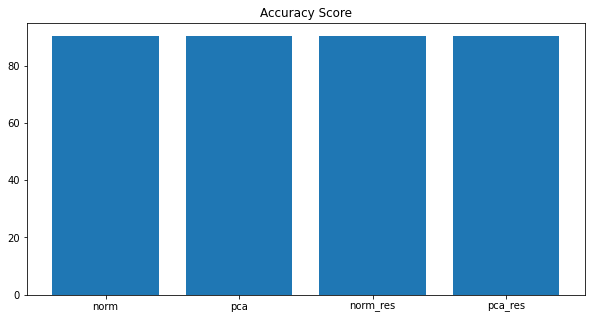

In [45]:
# Sort f1 results by value
acc_results = dict(sorted(acc_results.items(), key=lambda item: item[1], reverse=True))
print(acc_results)

# Plot f1 results
plt.figure(figsize=(10, 5))
plt.title('Accuracy Score')
plt.bar(acc_results.keys(), acc_results.values())
plt.show()

### Best models (F1 Score)

{'norm': 90.58531601226099, 'pca': 90.58531601226099, 'norm_res': 90.58531601226099, 'pca_res': 90.58531601226099}


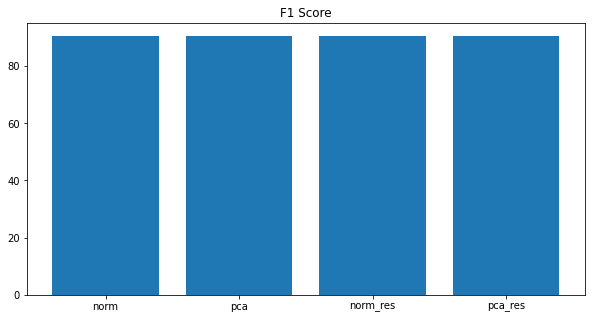

In [46]:
# Sort f1 results by value
f1_results = dict(sorted(f1_results.items(), key=lambda item: item[1], reverse=True))
print(f1_results)

# Plot f1 results
plt.figure(figsize=(10, 5))
plt.title('F1 Score')
plt.bar(f1_results.keys(), f1_results.values())
plt.show()

## Plot

0    10
5     7
2     5
1     5
4     3
3     1
Name: type, dtype: int64


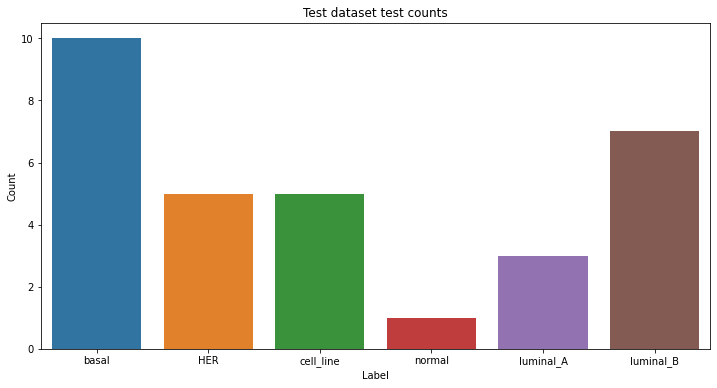

In [47]:
# Check how much values does each label have in test set
test_counts = norm_true.value_counts()
print(test_counts)

# plot test counts
plt.figure(figsize=(12, 6))
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.xticks(range(len(class_mapping)), class_mapping.keys())
plt.title('Test dataset test counts')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

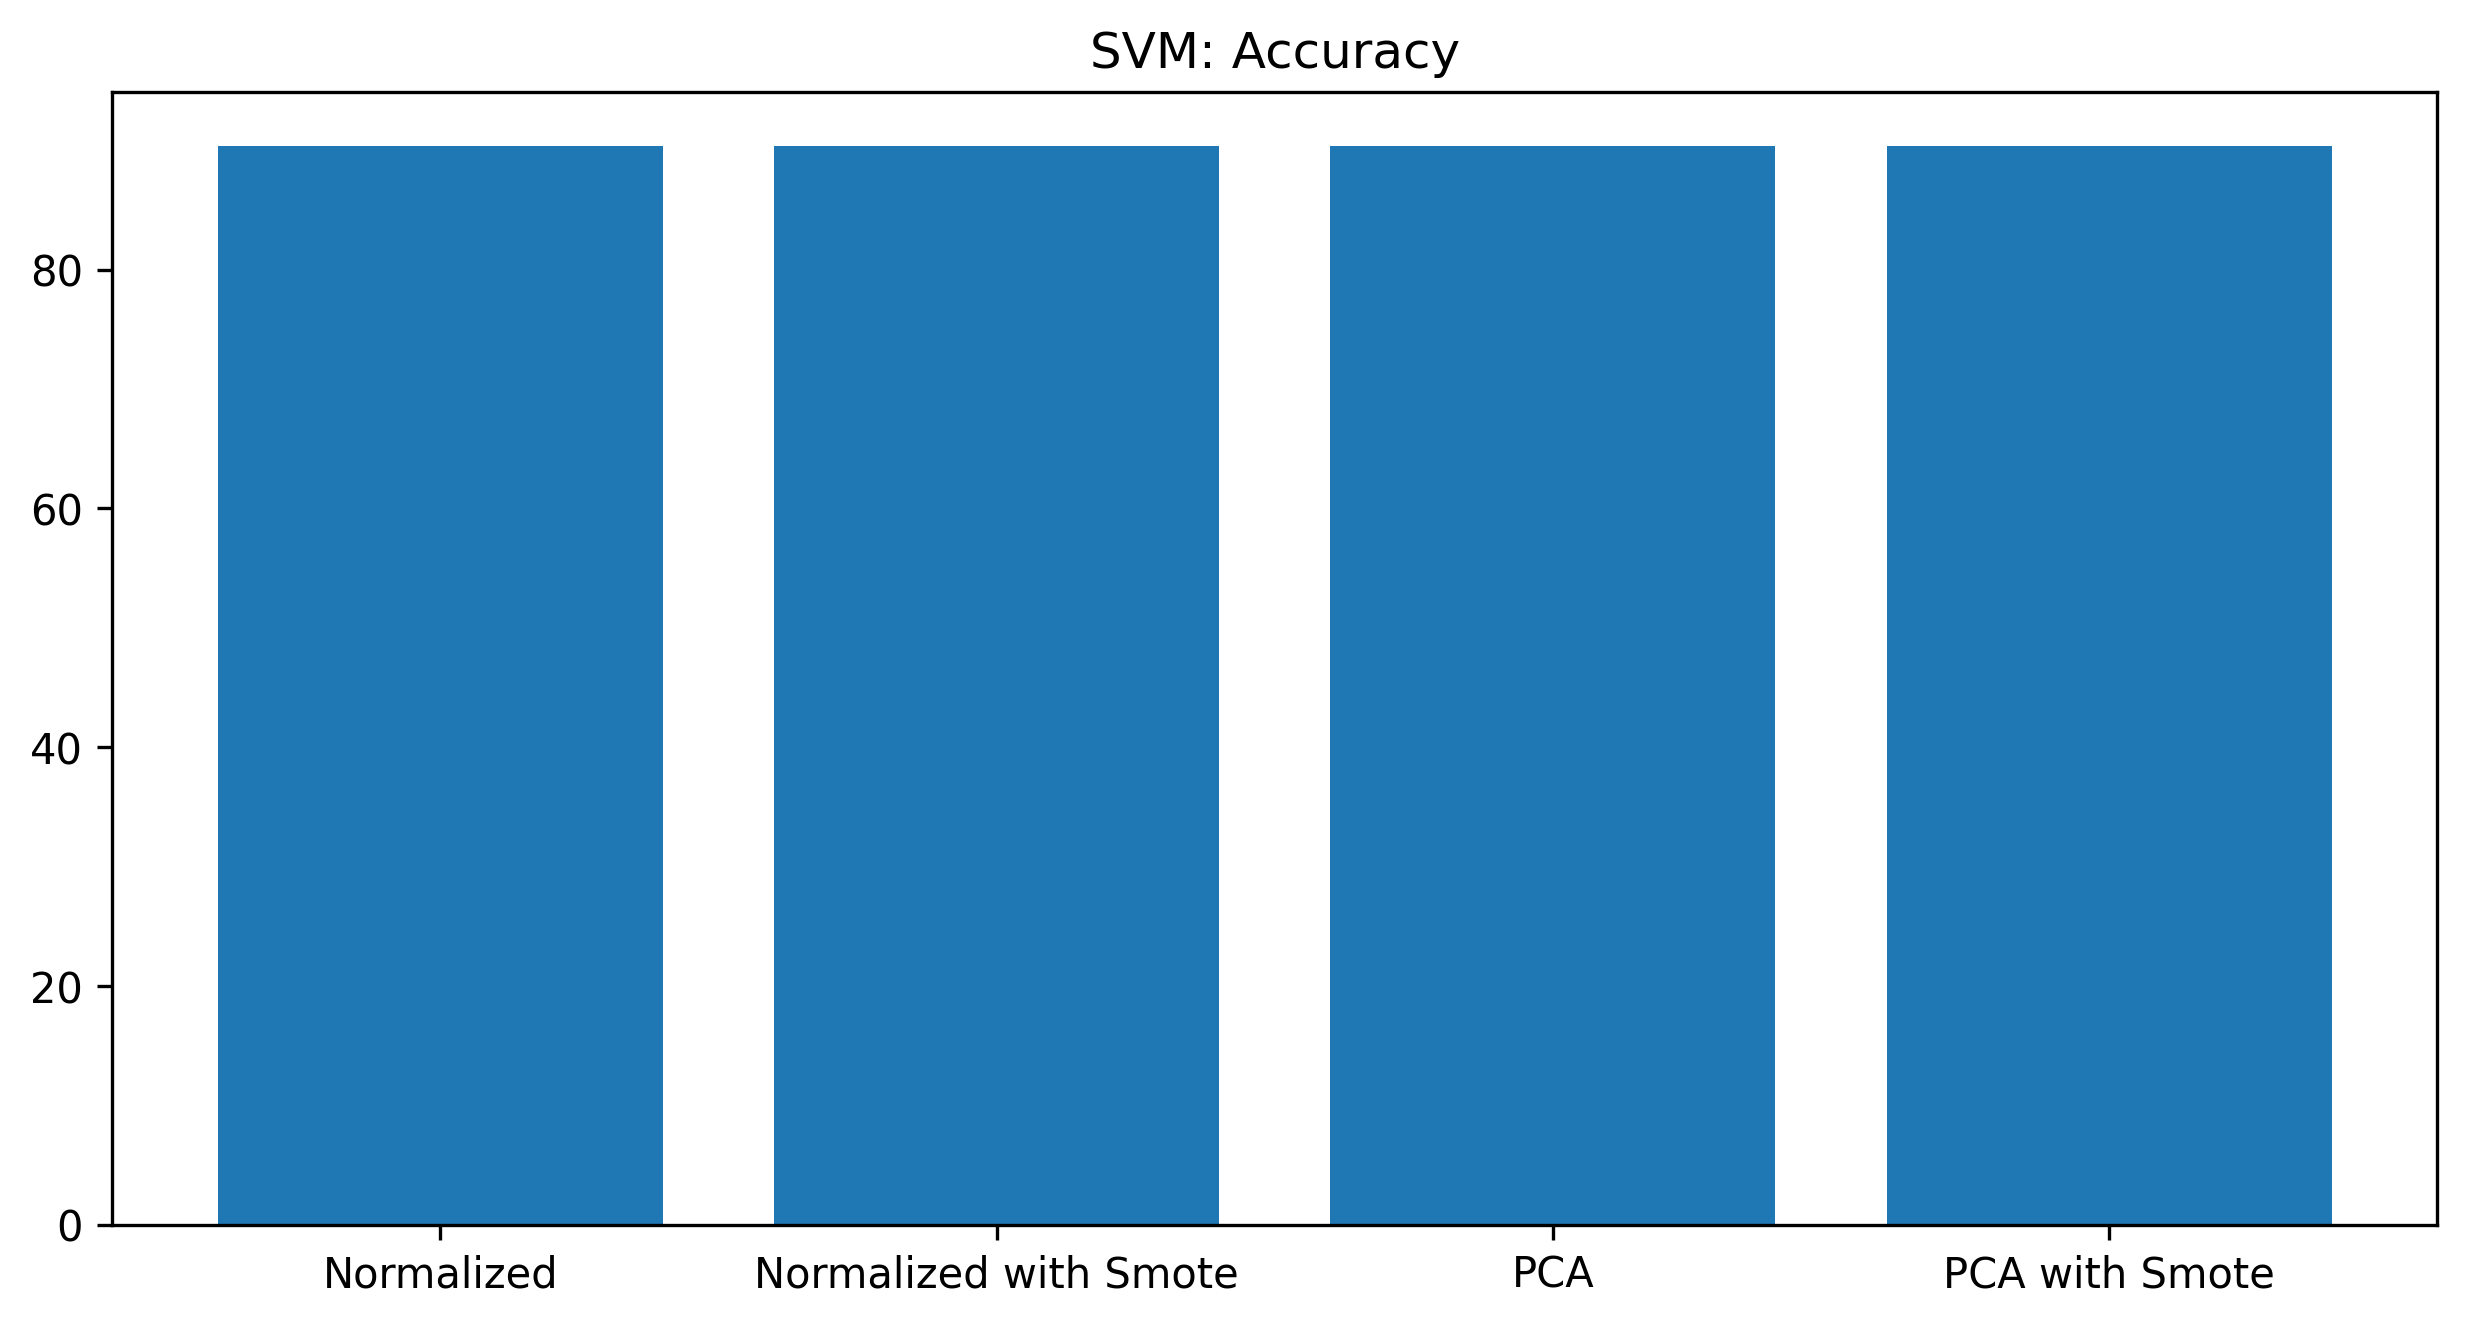

In [48]:
# Plot accuracy

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        norm_acc * 100,
        norm_res_acc * 100,
        pca_acc * 100,
        pca_res_acc * 100
    ]
)
plt.title('SVM: Accuracy')
plt.show()

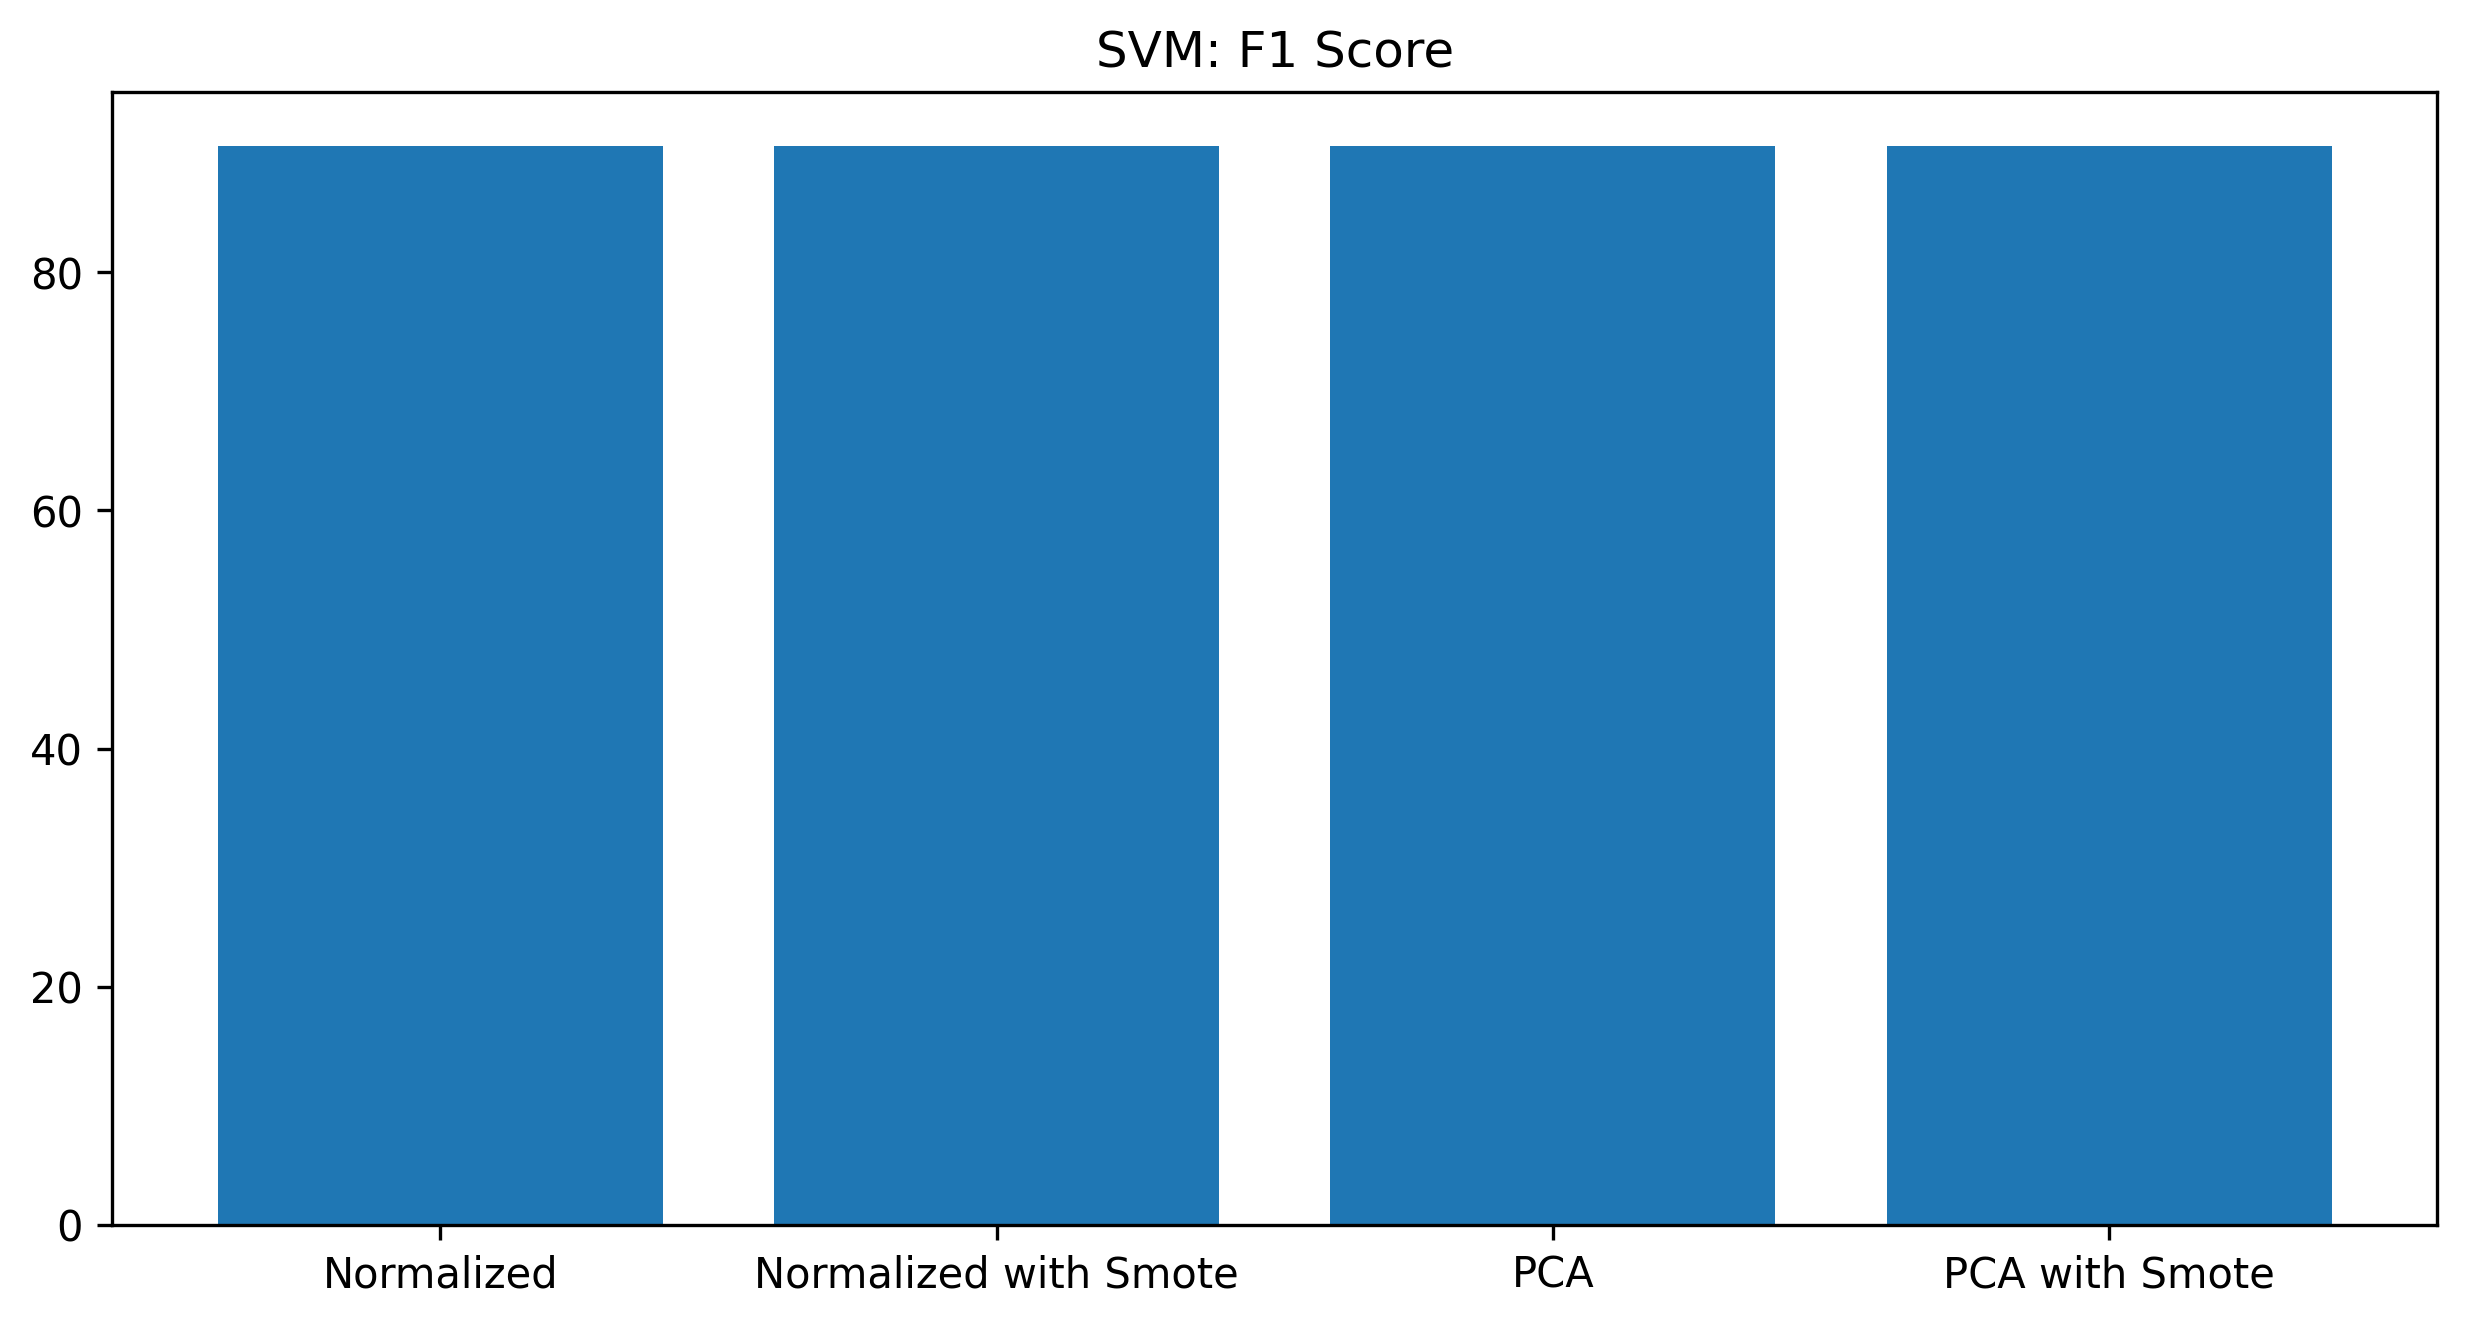

In [49]:
# Plot F1 score

plt.figure(figsize=(10, 5), dpi=300)
plt.bar(
    ['Normalized', 'Normalized with Smote', 'PCA', 'PCA with Smote'], 
    [
        norm_f1 * 100,
        norm_res_f1 * 100,
        pca_f1 * 100,
        pca_res_f1 * 100
    ]
)
plt.title('SVM: F1 Score')
plt.show()

## Best models 

1. Normalized oversampled
2. PCA oversampled
3. Normalized 
4. PCA

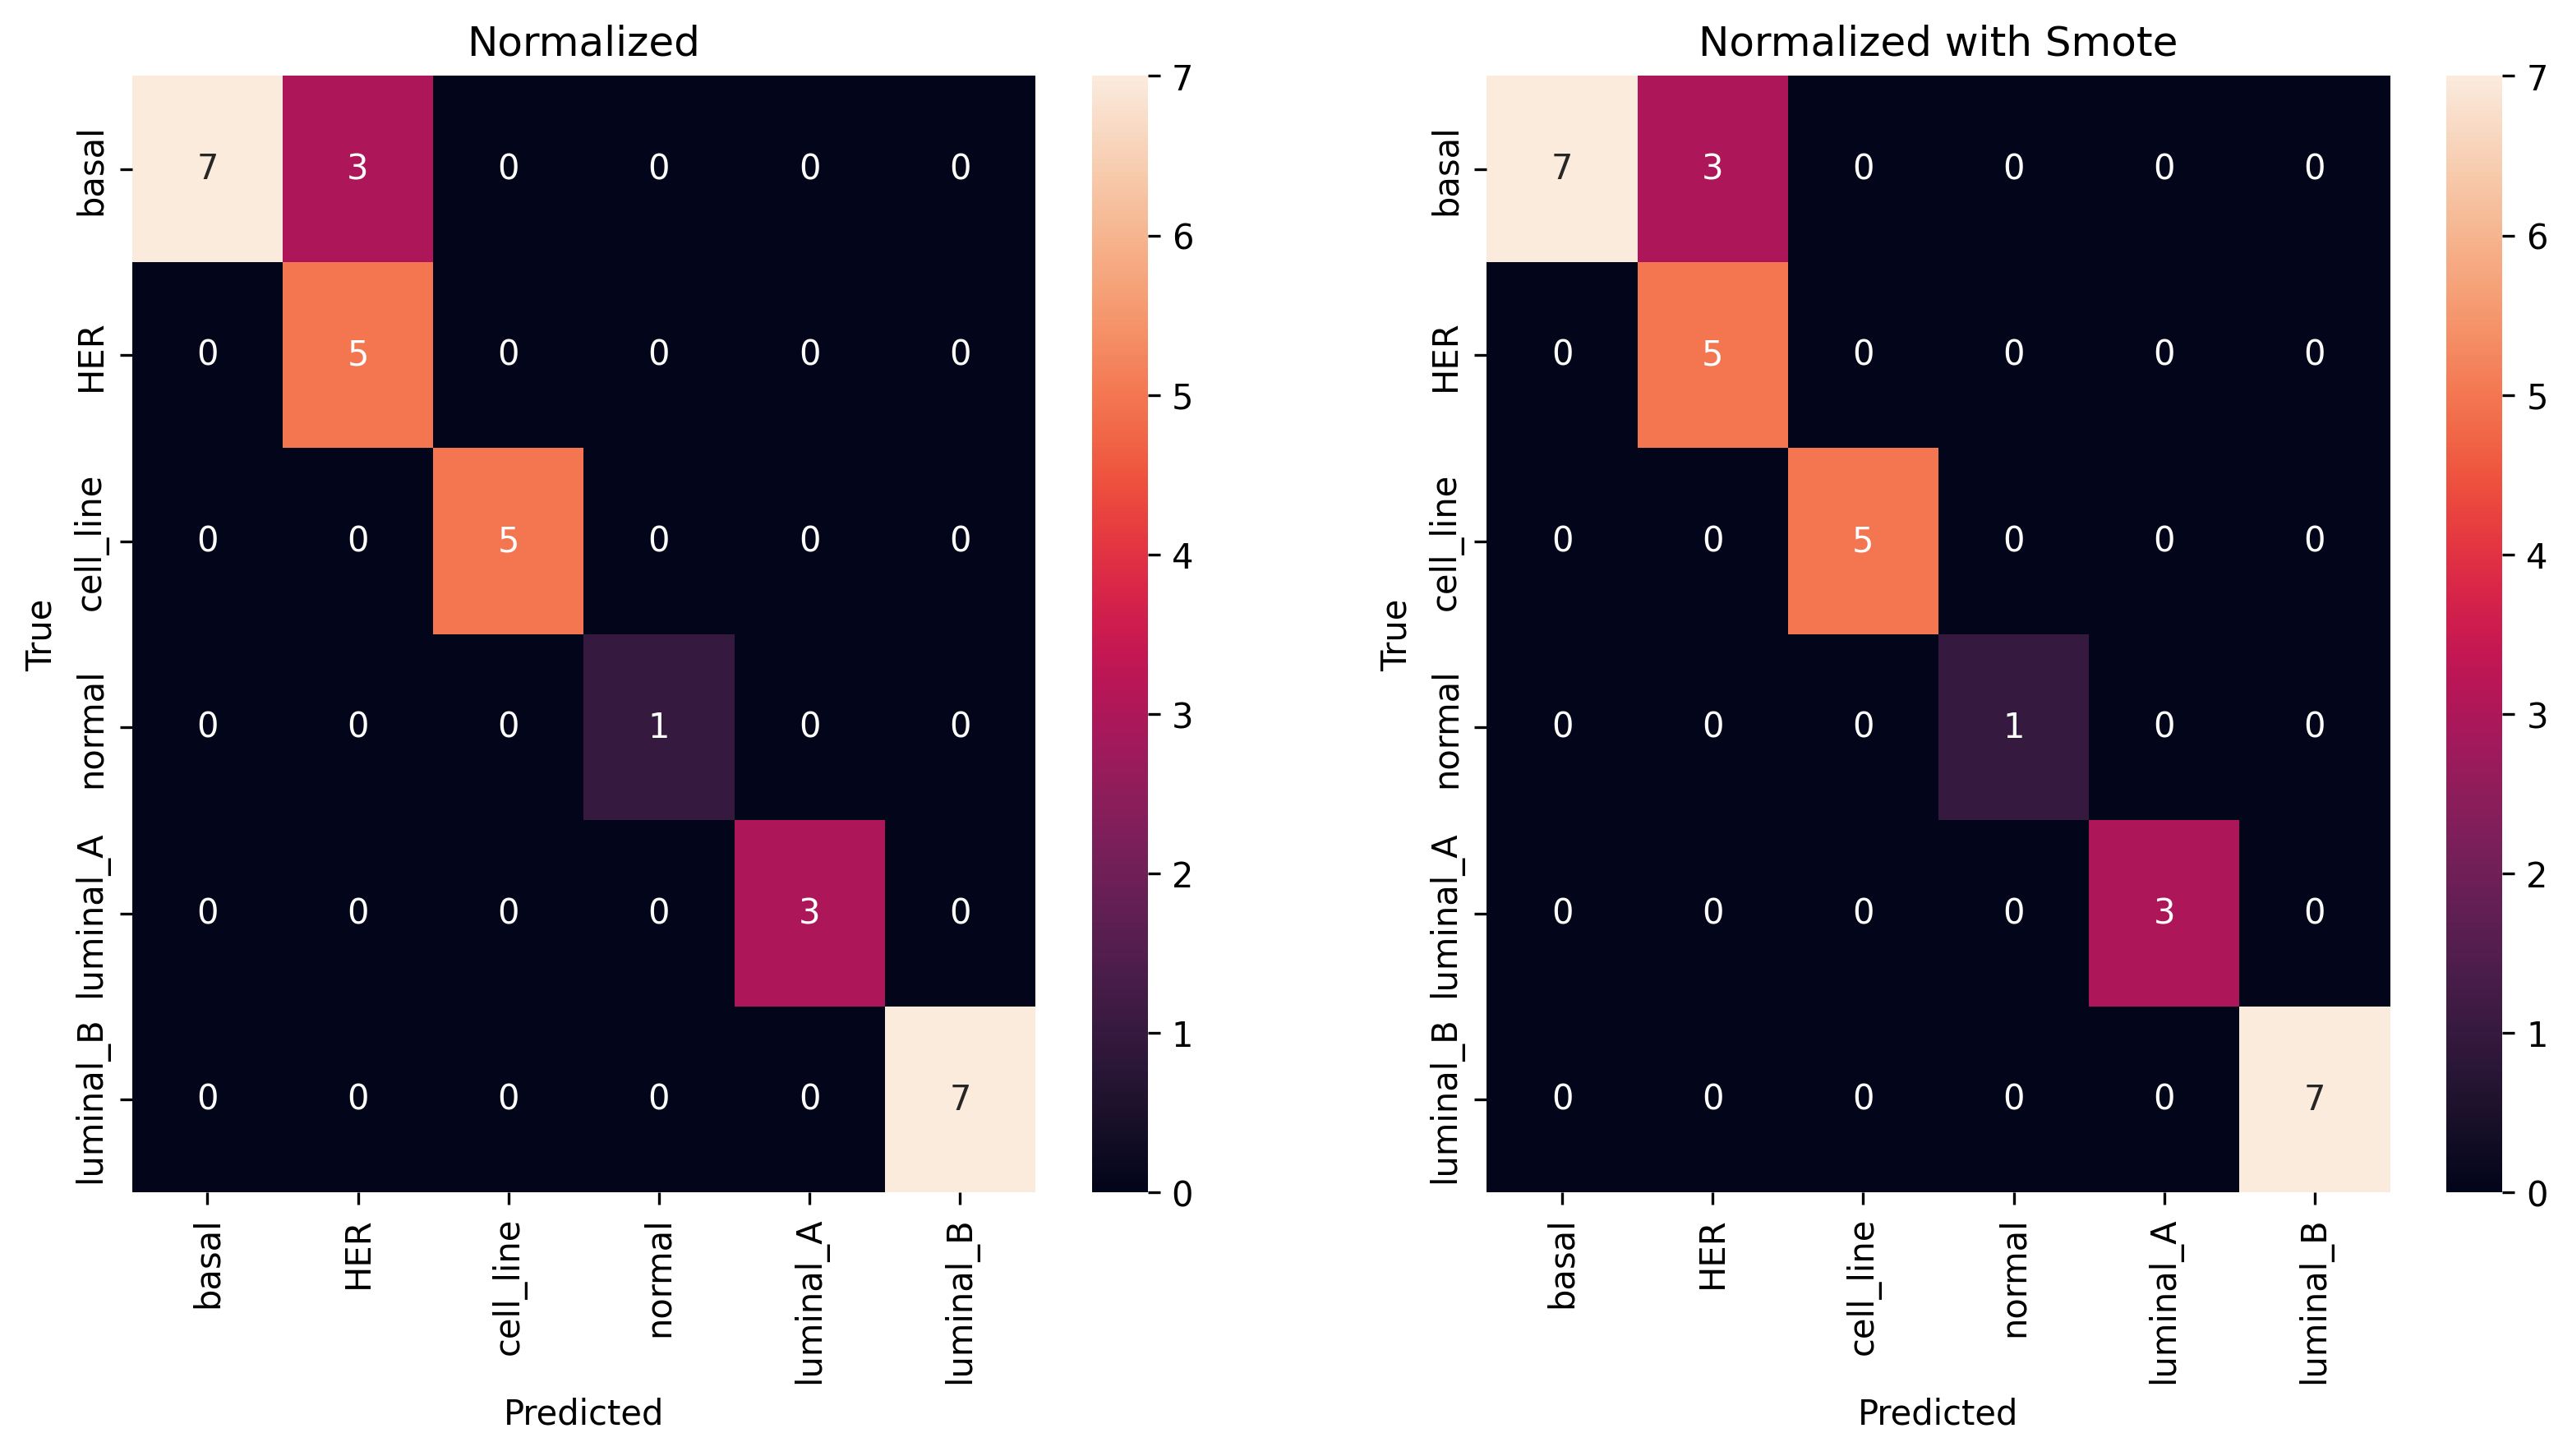

In [50]:
plt.figure(figsize=(13, 6), dpi=300)
plt.subplot(1, 2, 1)
plt.title('Normalized')
sns.heatmap(confusion_matrix(norm_true, norm_pred), annot=True, xticklabels=class_mapping, yticklabels=class_mapping, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(1, 2, 2)
plt.title('Normalized with Smote')
sns.heatmap(confusion_matrix(norm_res_true, norm_res_pred), xticklabels=class_mapping, yticklabels=class_mapping, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.show()

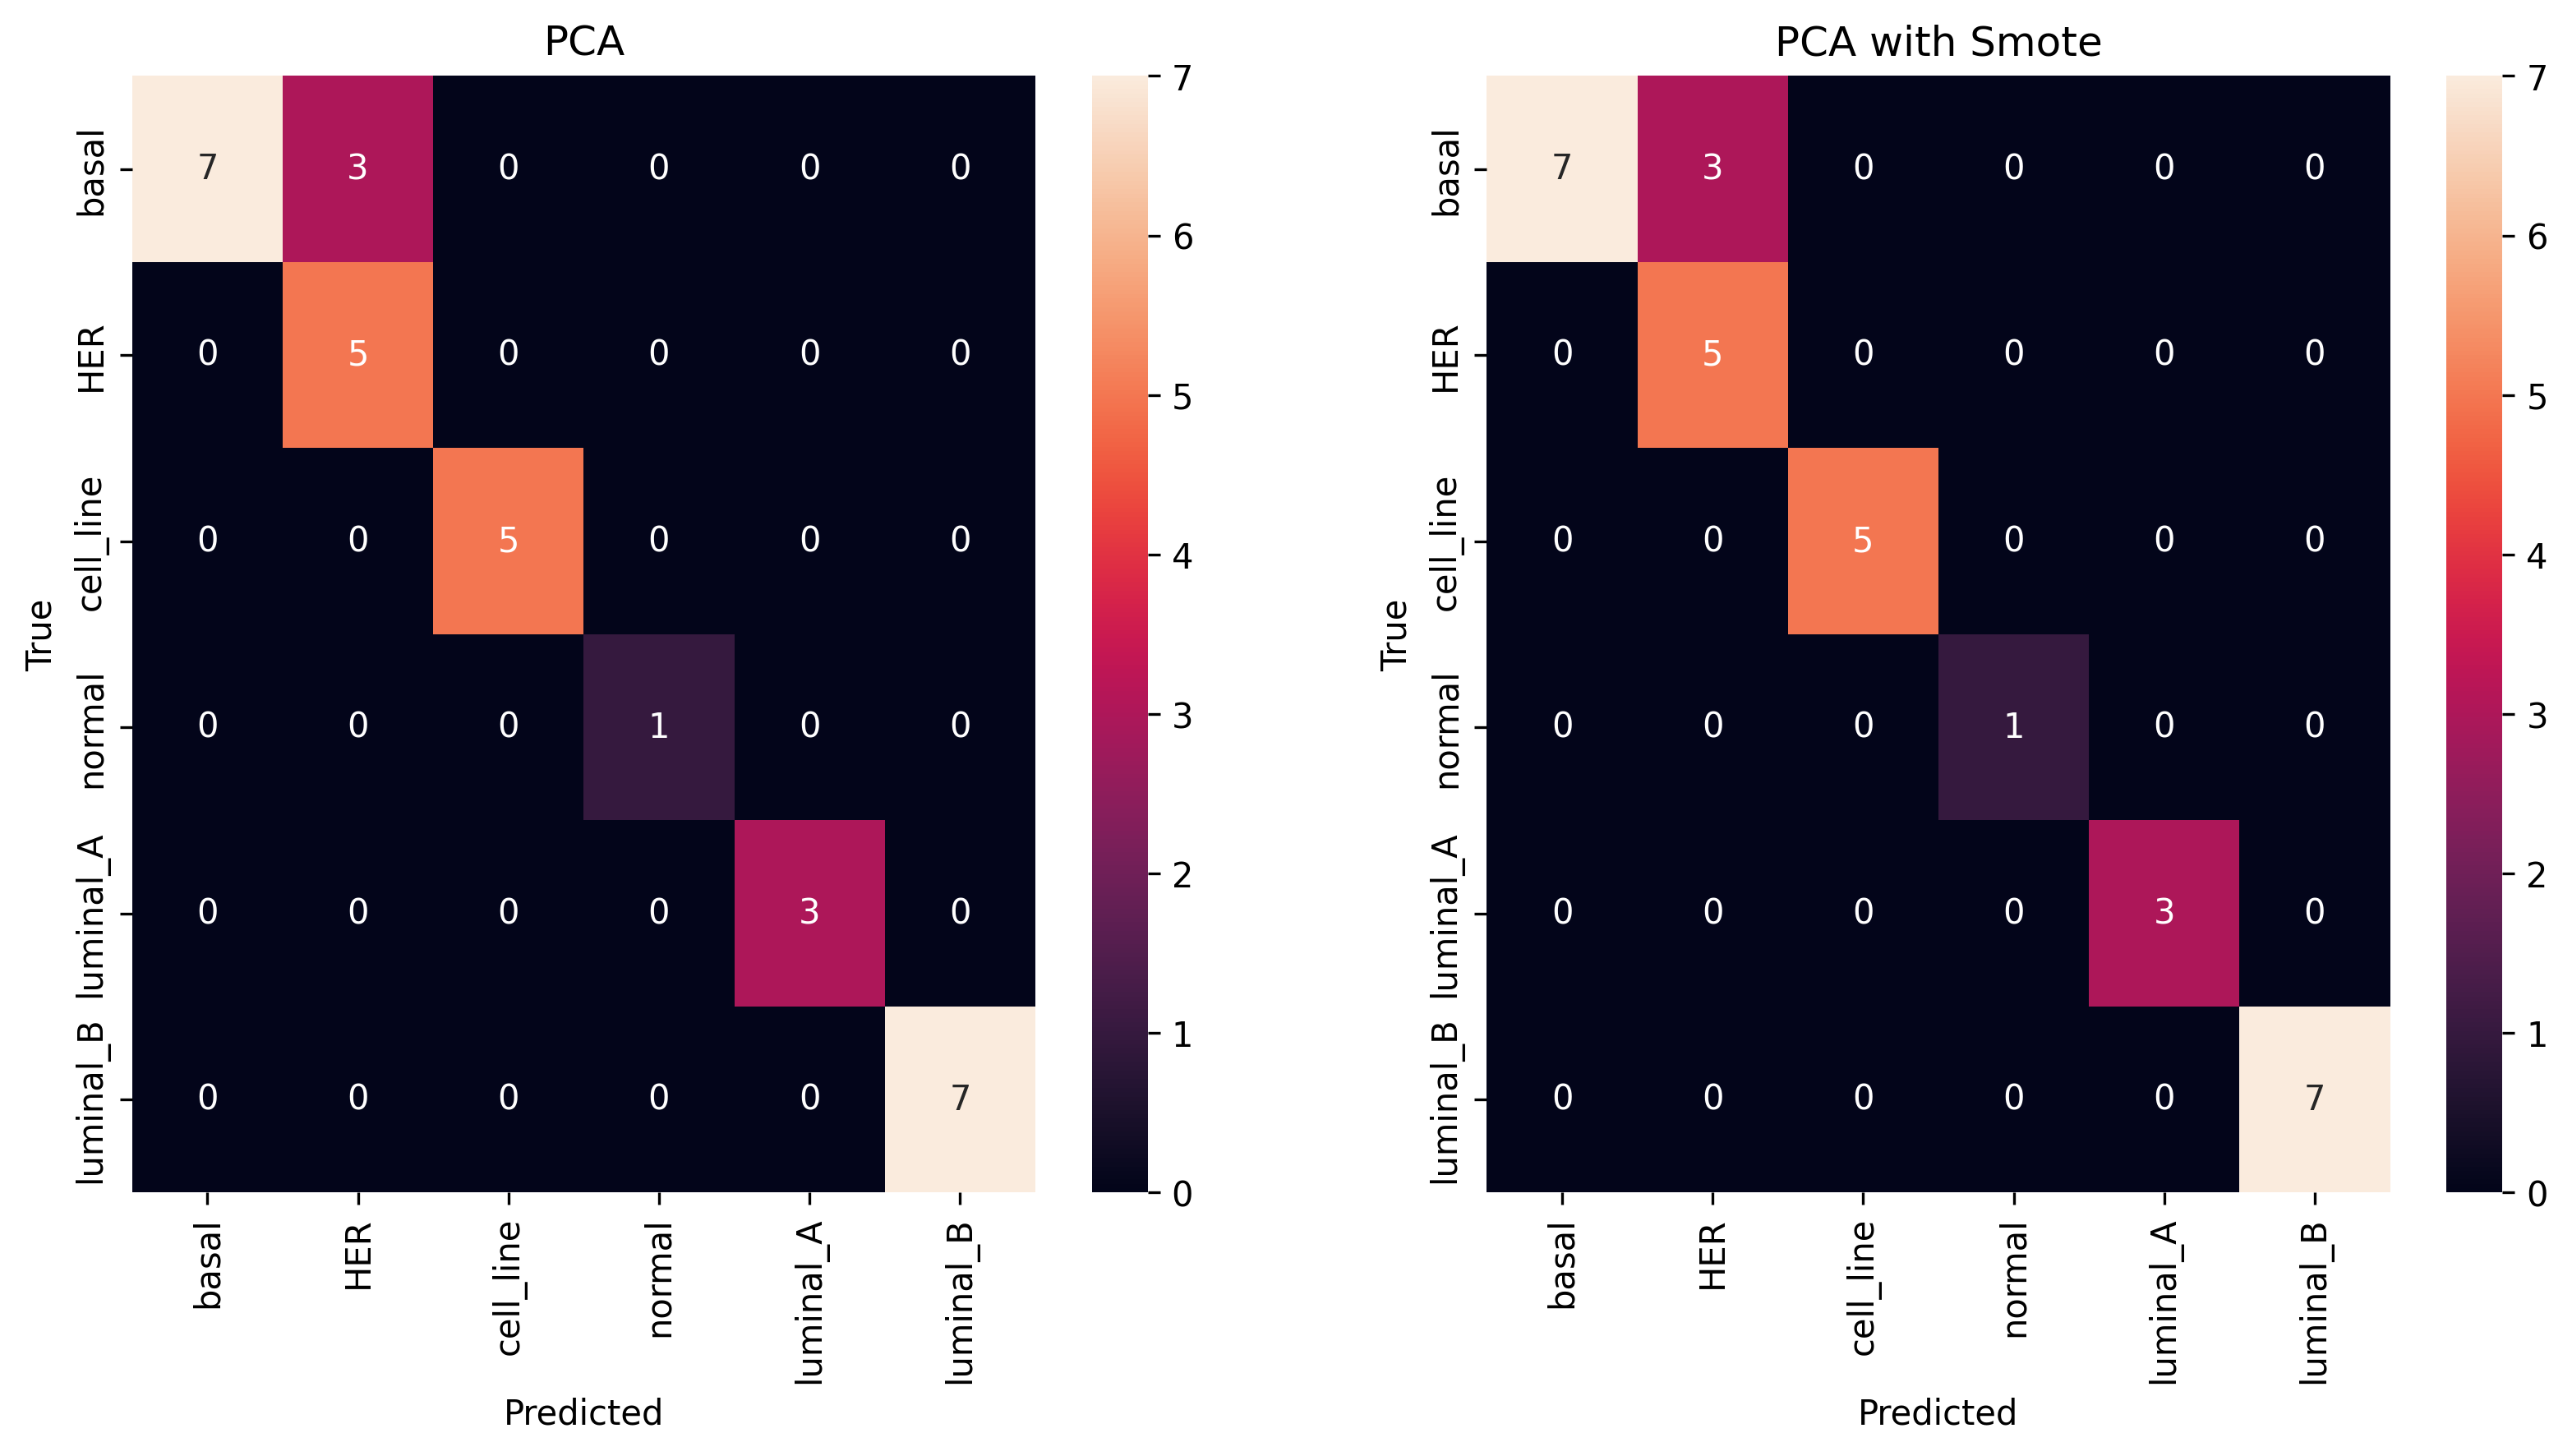

In [51]:
plt.figure(figsize=(13, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.title('PCA')
sns.heatmap(confusion_matrix(pca_true, pca_pred), annot=True, xticklabels=class_mapping, yticklabels=class_mapping, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(1, 2, 2)
plt.title('PCA with Smote')
sns.heatmap(confusion_matrix(pca_res_true, pca_res_pred), xticklabels=class_mapping, yticklabels=class_mapping, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.show()

## Save Models

In [52]:
if not os.path.exists(models_path):
    os.makedirs(models_path)

print('Saving models...', models_path)
pickle.dump(norm_model, open(models_path + 'norm_model.pickle', "wb"))
pickle.dump(norm_res_model, open(models_path + 'norm_res_model.pickle', "wb"))

pickle.dump(pca_model, open(models_path + 'pca_model.pickle', "wb"))
pickle.dump(pca_res_model, open(models_path + 'pca_res_model.pickle', "wb"))

print("Done!")

Saving models... saved_models/SVM/
